# Astros Cheating Scandal: Using Trashcan Data

## Introduction to the Problem

The Astros Cheating Scandal is the biggest MLB scandal to date; the largest punishments ever were given out for the unprofessional behavior and actions of the team in the 2017 and 2018 seasons. Just to recap the scandal for anyone unaware, the Astros used HD cameras to steal the signs the catcher gives the pitcher, along with other methods. The camera feed was livestreamed to their dugout, where they would bang a trash can signaling their hitter what type of pitch would come next (fastball or off-speed). I simple advantage like this can go a huge way in baseball, where the best hitters in the game hit .300 and an average player hits .250. Hitting a baseball at the MLB level is extremely difficult, so every advantage the hitter can get goes a long way. Considering the Astros used this underhanded method during the 2017 season when they won the World Series Trophy, it was hotly debated whether their trophy should be stripped from them. The commisioner decided not to strip away the trophy, but handed out extreme punishments for the club: 

-   Suspended Manager AJ Hinch and General Manager Jeff Luhnow for one year (Astros owner Jim Crane has since fired both)
-   1st and 2nd round picks for 2020 and 2021 were stripped from team entirely
-   Fined $ 5 million, the max amount allowed under MLB Constitution

While no players were directly suspended, the Astros Club is taking a huge setback by losing it's management and losing these draft picks. For more background on the Astros Cheating Scandal, click [here](https://www.si.com/mlb/2020/01/13/houston-astros-cheating-punishment).

## Problem and Approach

I'm attempting to predict whether the Astros will cheat during an at bat based on conditions during the game. The data was recorded from auditory trash can banging from the Astros' dugout, signaling whether a fastball or breaking ball was coming, to the batter. While this information is Astros specific, hopefully we can glean more insight into the conditions they would most often cheat so umpires can prepare for potential future scandals.

The data for this problem was taken from 

## Initial Data Cleaning

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# Read in dataframe. Shape is (8274, 29)
df = pd.read_csv('https://raw.githubusercontent.com/mtoce/Build2-Project/master/astros_bangs_20200127.csv')

# Define target as whether bangs were heard during batter's AB
# Bangs were used by the Astros after using technology to steal signs to signal to the batter what pitch was coming
y = 'has_bangs'

In [23]:
def wrangle(X):
    '''
    Wrangle function for DF before train_test_split
    '''

    X = X.copy()

    # Change game_date to a datetime to grab month (could be useful in predicting)
    X['game_date'] = pd.to_datetime(X['game_date'], infer_datetime_format=True)
    X['game_month'] = X['game_date'].dt.month

    # Replace some character strings with numbers for ease of use in models
    X['has_bangs'] = X['has_bangs'].replace({'n': 0, 'y': 1})
    X['on_1b'] = X['on_1b'].replace({'t': 1, 'f': 0})
    X['on_2b'] = X['on_2b'].replace({'t': 1, 'f': 0})
    X['on_3b'] = X['on_3b'].replace({'t': 1, 'f': 0})

    # Drop these columns since they are video playback related or contain no cardinality
    X = X.drop(columns=['youtube_id', 'pitch_youtube_seconds', 'youtube_url', 
                    'pitch_datetime', 'game_pitch_id', 'event_number', 
                    'pitch_playid', 'atbat_playid', 'bangs'])

    # Save only data where bangs occured (95% of df), remove the rest
    games_with_bangs_list = X[(X[y] == 1)].game_date.to_list()
    X = X[X['game_date'].isin(games_with_bangs_list)]

    # Remove rows with runners getting out to end the inning (<.2% of outcomes)
    # Since it will conflict with any batting average and obp calculations
    no_interference = ['Home Run', 'Single', 'Strikeout', 'Double Play', 
                   'Grounded Into DP', 'Flyout', 'Groundout', 'Lineout', 'Walk',
                   'Sac Fly', 'Pop Out', 'Double', 'Forceout', 'Field Error', 
                   'Sac Bunt', 'Hit By Pitch', 'Strikeout - DP', 'Triple', 
                   'Fielders Choice Out', 'Bunt Groundout', 'Bunt Pop Out']
    
    # Remove the outliers where the outcome of the batter's AB was interference, giving the runner a base (for batting average calculations)
    X = X[X['at_bat_event'].isin(no_interference)]

    # Drop columns that may contain data leakage (such as the exact day where they may have cheated a lot for no real reason)
    X = X.drop(['game_date', 'game_id'], axis=1)

    return X

df = wrangle(df)

In [24]:
# Feature engineering function
def feature_engineering(X):
  '''
  Engineer new features for dataframe X.
  '''
  # define list for ways batter can get a hit / on_base / out
  hit_list = ['Single', 'Double', 'Triple', 'Home Run']
  obp_list = ['Single', 'Double', 'Triple', 'Home Run', 'Walk', 'Hit By Pitch', 'Sac Fly']
  out_list = ['Strikeout', 'Double Play',
       'Grounded Into DP', 'Catcher Interference', 'Flyout', 'Groundout',
       'Lineout', 'Sac Fly', 'Fan interference', 'Pop Out',
       'Double', 'Forceout', 'Sac Bunt', 'Strikeout - DP', 'Fielders Choice Out',
       'Bunt Groundout', 'Bunt Pop Out']

  # define new features for batter's -At Bat- outcome (AB)
  X['batter_hit'] = X['at_bat_event'].isin(hit_list)
  X['batter_base'] = X['at_bat_event'].isin(obp_list)
  # replace 
  X['batter_hit'] = X['batter_hit'].replace({True: 1, False: 0})
  X['batter_base'] = X['batter_base'].replace({True: 1, False: 0})                                        
  return X

df = feature_engineering(df)

In [25]:
!pip install category_encoders

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_curve

In [27]:
#help('modules')

In [28]:
import category_encoders as ce

In [29]:
# create a features DF without the target
X = df.drop(y, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, df[y], test_size=0.2, random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=17) # 0.25 x 0.8 = 0.2\

In [30]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_curve

In [31]:
pipeline = make_pipeline(
    SimpleImputer(),
    ce.OrdinalEncoder(),
    SelectKBest(),
    RandomForestClassifier(n_jobs=-1, n_estimators=24),
)

In [32]:

# Use this for actual hyperparameter tuning
# param_distributions = {
#     'randomforestclassifier__n_estimators': [25],
#     'randomforestclassifier__max_depth': [None, 30, 32, 34, 36],
#     'randomforestclassifier__min_samples_split': [6, 8, 10, 12, 14],
#     'randomforestclassifier__criterion': ['gini', 'entropy'],
#     'randomforestclassifier__min_samples_leaf': [1, 2],
#     'randomforestclassifier__max_leaf_nodes': [None],
#     'randomforestclassifier__oob_score': [True, False],
#     'selectkbest__k': [10, 15, 20, 25, 30],
#     'simpleimputer__strategy': ['most_frequent'],
# }

# Use this for final model (one parameter each)
param_distributions = {
    'randomforestclassifier__n_estimators': [250],
    'randomforestclassifier__max_depth': [32],
    'randomforestclassifier__min_samples_split': [10],
    'randomforestclassifier__criterion': ['entropy'],
    'randomforestclassifier__min_samples_leaf': [2],
    'randomforestclassifier__max_leaf_nodes': [None],
    'randomforestclassifier__oob_score': [True],
    'selectkbest__k': [10],
    'simpleimputer__strategy': ['most_frequent'],
}

In [33]:
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=1,
    cv=5,
    scoring='accuracy',
    verbose=0,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train)

C:\Users\Mike\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 5 16] are constant.
  UserWarning)
C:\Users\Mike\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,
                                                            missing_values=nan,
                                                            strategy='mean',
                                                            verbose=0)),
                                             ('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='valu

In [34]:
pipeline = search.best_estimator_

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

pipeline.score(X_test, y_test)

y_pred_prob = pipeline.predict_proba(X_val)[:, 1]

C:\Users\Mike\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 5 16] are constant.
  UserWarning)
C:\Users\Mike\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


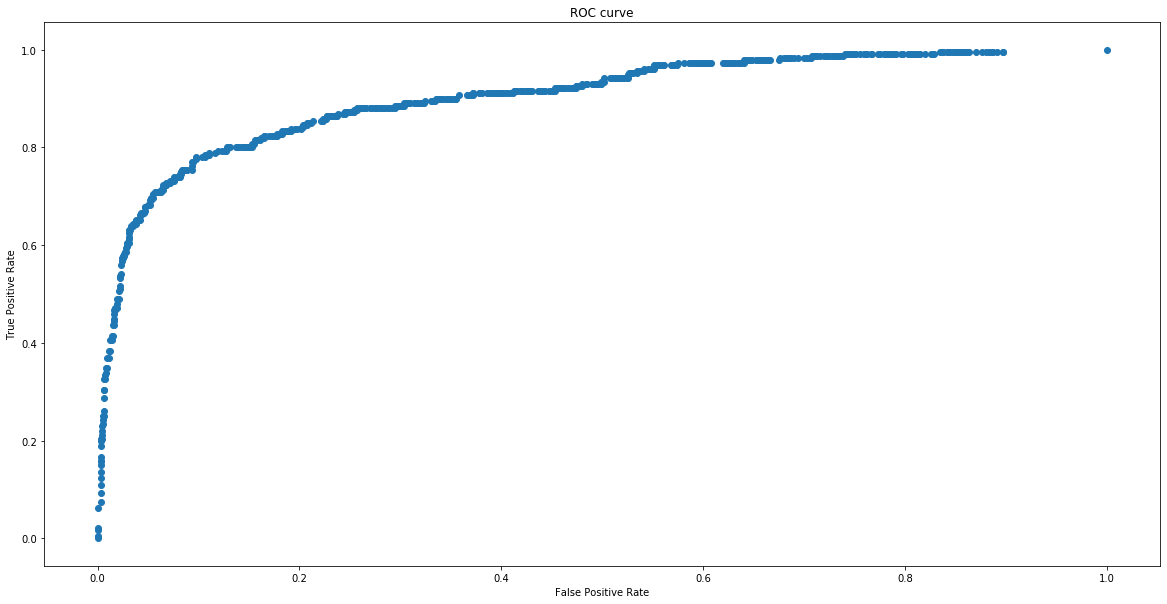

In [35]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

# Figure: ROC_AUC_graph
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [36]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred_prob)

print('Best hyperparameters: ', search.best_params_)
print('Cross-validation Accuracy: ', search.best_score_)
print('ROC_AUC_Score', roc_auc_score(y_val, y_pred_prob))

Best hyperparameters:  {'simpleimputer__strategy': 'most_frequent', 'selectkbest__k': 10, 'randomforestclassifier__oob_score': True, 'randomforestclassifier__n_estimators': 250, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_leaf_nodes': None, 'randomforestclassifier__max_depth': 32, 'randomforestclassifier__criterion': 'entropy'}
Cross-validation Accuracy:  0.9053968253968254
ROC_AUC_Score 0.9035069085870404


In [37]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = rf.feature_importances_

# define standard deviation for graph
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

In [38]:
# Print the feature rank
for f in range(len(indices)):
    print(X.columns[indices][f])

top_bottom
inning
game_pk
pitch_type_code
final_home_runs
at_bat_event
opponent
final_away_runs
pitch_category
batter


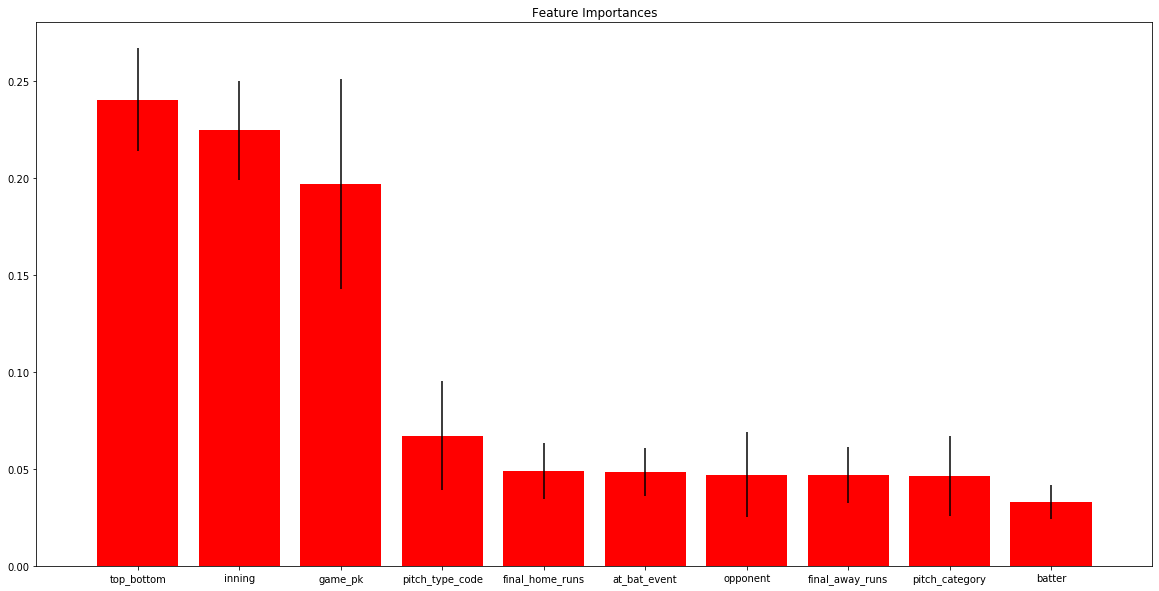

In [39]:
# Plot feature importances
plt.figure()
plt.rcParams["figure.figsize"] = (20, 10)
plt.title("Feature Importances")
plt.bar(range(len(indices)), importances[indices], color='red', yerr=std[indices], align="center")
plt.xticks(range(len(indices)), X.columns[indices])
plt.xlim([-1, len(indices)])
plt.show()